# Clasificación por KNN

Cargamos los paquetes


In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import shap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

Cargamos los datos, definimos el grid de hiperparámetros y hacemos la búsqueda en cuadrícula


In [10]:
df = pd.read_csv("../data/match_data_compact.csv")
X = df.drop("blueTeamWin", axis=1)
y = df["blueTeamWin"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val)

pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    "knn__n_neighbors": [103, 105, 107],
    "knn__weights": ['uniform', 'distance'],
    "knn__metric": ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'knn__metric': ['euclidean', 'manhattan'], 'knn__n_neighbors': [103, 105, ...], 'knn__weights': ['uniform', 'distance']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,with_centering,True


In [ ]:
best_model = grid_search.best_estimator_
print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor accuracy en CV: {grid_search.best_score_:.4f}")

y_pred = best_model.predict(X_val)
print("Matriz de Confusión:")
print(confusion_matrix(y_val, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_val, y_pred, target_names=["Red Team Win", "Blue Team Win"]))

Mejores hiperparámetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 103, 'knn__weights': 'distance'}
Mejor accuracy en CV: 0.7531
Matriz de Confusión:
[[1919  530]
 [ 610 1785]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      2449
           1       0.77      0.75      0.76      2395

    accuracy                           0.76      4844
   macro avg       0.76      0.76      0.76      4844
weighted avg       0.76      0.76      0.76      4844



Visualización


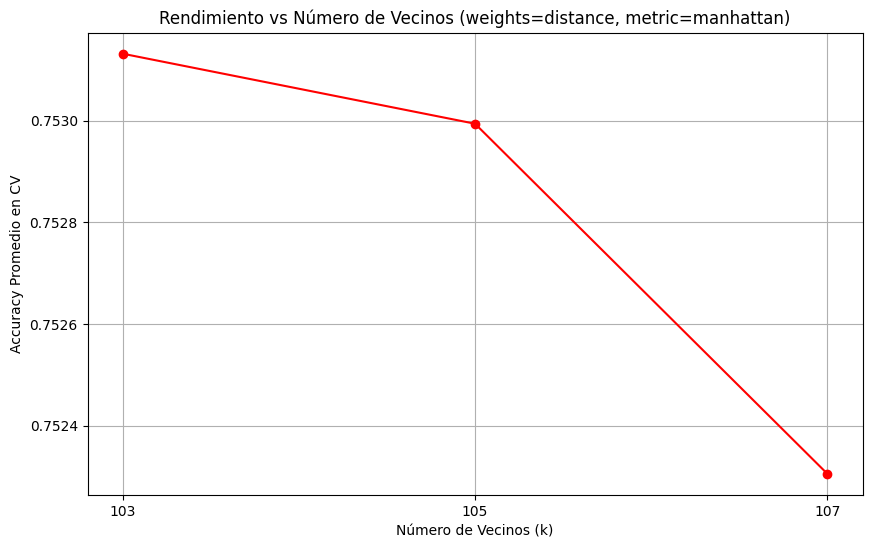

In [12]:
results = pd.DataFrame(grid_search.cv_results_)
best_weight = grid_search.best_params_['knn__weights']
best_distance = grid_search.best_params_['knn__metric']
results = results[(results['param_knn__weights'] == best_weight) & (results['param_knn__metric'] == best_distance)]

plt.figure(figsize=(10, 6))
plt.plot(results['param_knn__n_neighbors'], results['mean_test_score'], marker='o', color='r')
plt.title(f'Rendimiento vs Número de Vecinos (weights={best_weight}, metric={best_distance})')
plt.xlabel('Número de Vecinos (k)')
plt.ylabel('Accuracy Promedio en CV')
plt.xticks(results['param_knn__n_neighbors'])
plt.grid()
plt.show()

Interpretabilidad con SHAP


In [13]:
def predict_proba_wrapper(data):
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data, columns=X_train.columns)
    return best_model.predict_proba(data)


# Seleccionamos una muestra del conjunto de test para acelerar el cálculo de SHAP
sample_data = shap.sample(X_val, 50, random_state=0)

# Obtenemos el explainer SHAP
explainer = shap.KernelExplainer(predict_proba_wrapper, sample_data)

# Calculamos los valores SHAP para el conjunto de test
instance = X_val.iloc[[0]]
shap_values = explainer.shap_values(instance)

  0%|          | 0/1 [00:00<?, ?it/s]

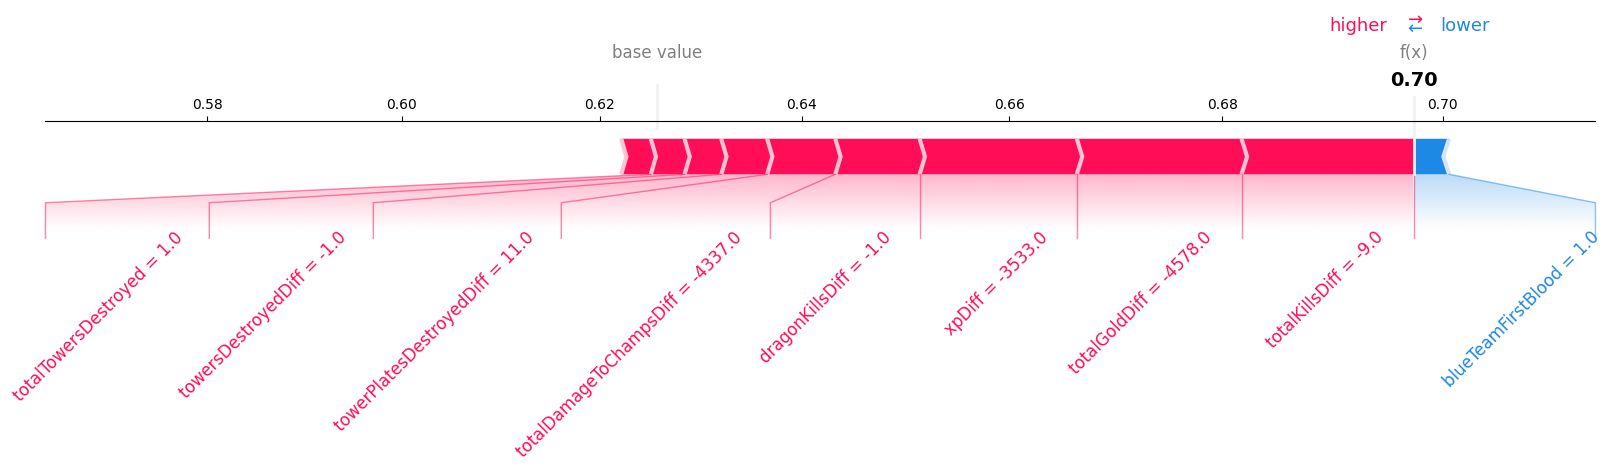

In [14]:
# Visualizamos los valores SHAP
shap.initjs()
shap.force_plot(
    explainer.expected_value[0],
    shap_values[0][:, 0],
    instance.iloc[0],
    matplotlib=True,
    text_rotation=45,
    link="logit"
)

In [15]:
shap_values_summary = explainer.shap_values(sample_data)

  0%|          | 0/50 [00:00<?, ?it/s]

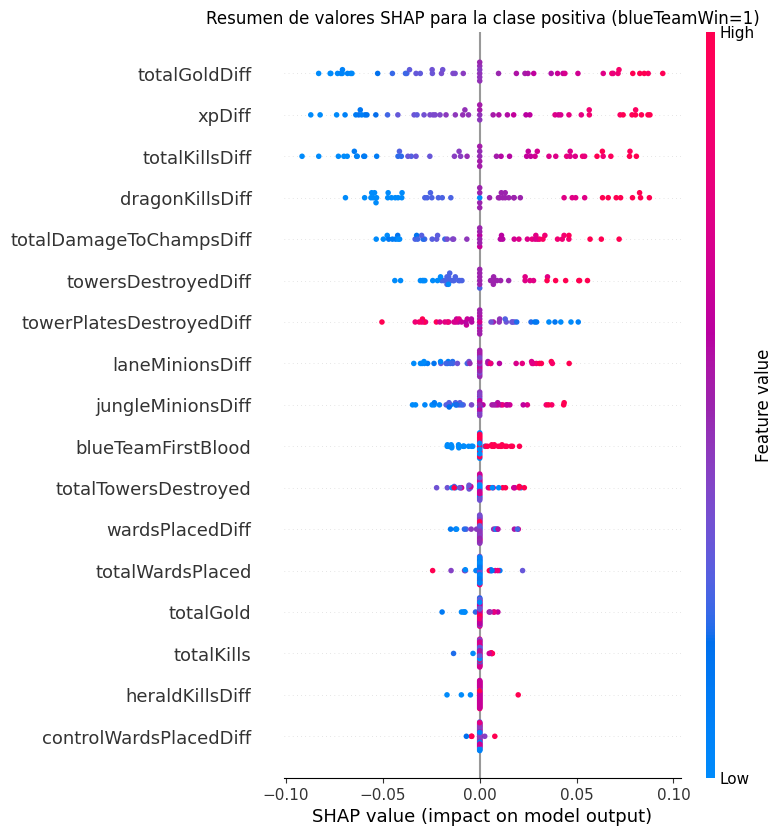

In [ ]:
plt.figure(dpi=100)
shap.summary_plot(
    shap_values_summary[:, :, 1],
    sample_data,
    plot_type="dot",
    show=False
)
plt.title("Resumen de valores SHAP para la clase positiva (blueTeamWin=1)")
plt.show()